In [2]:
from plotting import load_results_df, get_metrics, plot_perf, plot_single_metric, create_corr_df, PRETRAINED_MODELS, TASK2VEC_IGNORE_MODELS
import re
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
sns.set()

metric_sweep_names = ['h3vfn2jq', 'yqqueg03', 'fooseueo', 'oxaule4c', '1epe7p4c', '8w3i470v', '9njpiyg2', 'ul50eaul', 'btwijwf5']
transfer_sweep_names = ['umzfq5ap', 'wo8h5zjv',
                        'v08vpocw', '1ga7pdck', 't1h73wt7', 'qggc7h5k', 'kwun07sq', '9z8c4aih']

perf_df, metrics_df = load_results_df(
    metric_sweep_names=metric_sweep_names, 
    transfer_sweep_names=transfer_sweep_names)
metrics_df.to_csv('all_metrics.csv')
metrics = get_metrics(metrics_df)

In [2]:
pt_perf = perf_df[perf_df['pretrained'] == True]
pt_perf = pt_perf.groupby(['model', 'dataset', 'n_classes_per_task', 'domain_inc'], as_index=False).mean()[['model', 'dataset', 'n_classes_per_task', 'domain_inc', 'mean_iid_acc', 'cl_acc', 'mean_fgt']]

In [64]:
# import itertools

# def dict_product(dicts):
#     return list(dict(zip(dicts, x)) for x in itertools.product(*dicts.values()))


# agg_cols = ['model', 'dataset', 'n_classes_per_task', 'domain_inc']
# combinations = dict_product({x: list(perf_df[x].unique()) for x in agg_cols})
# s = set()
# for c in combinations:
#     subset = perf_df.loc[
#         (perf_df.dataset == c['dataset']) &
#         (perf_df.n_classes_per_task == c['n_classes_per_task']) &
#         (perf_df.model == c['model']) &
#         (perf_df.domain_inc == c['domain_inc'])
#     ]
#     num_samples = subset.shape[0]
#     s.add(num_samples)
#     if num_samples == 1 or num_samples == 2:
#         perf_df = perf_df.drop(subset.index)
# print(s)
# print(perf_df.shape)


{0, 3}
(372, 100)


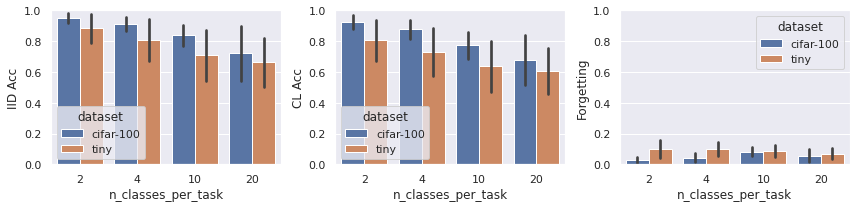

In [32]:
plot_perf(perf_df, hue='dataset', x='n_classes_per_task',
          figsize=(12, 3), savefig='../figures/perf.png', domain_inc=False, transfer=False)

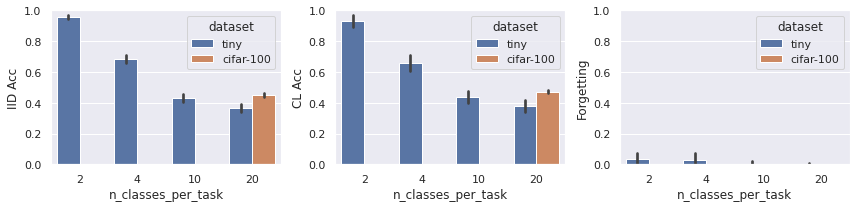

In [3]:
plot_perf(perf_df, hue='dataset', x='n_classes_per_task',
          figsize=(12, 3), savefig='../figures/perf.png', domain_inc=True, transfer=False)

In [10]:
corr_df = create_corr_df(metrics_df.copy(), [m for m in metrics if 'diff' not in m and 'norm' not in m], idx=True, perf_metrics=['all_cl_accs', 'all_fgts', 'all_transfers'])
corr_df.to_csv('corr_df.csv')
corr_df = corr_df.groupby(
    ['model', 'dataset', 'domain_inc', 'pretrained', 'perf_metric', 'sim_metric'], as_index=False).mean()
corr_df = corr_df.drop(labels=['n_classes_per_task', 'task_idx'], axis=1)


/home/mila/o/omar.salemohamed/.virtualenvs/tasksim/lib/python3.9/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/mila/o/omar.salemohamed/.virtualenvs/tasksim/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/mila/o/omar.salemohamed/.virtualenvs/tasksim/lib/python3.9/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/mila/o/omar.salemohamed/.virtualenvs/tasksim/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/mila/o/omar.salemohamed/.virtualenvs/tasksim/lib/python3.9/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/

In [ ]:
for perf_metric in corr_df['perf_metric'].unique():
    for setting in corr_df['domain_inc'].unique():
        df = corr_df[(corr_df['perf_metric'] == perf_metric) & (corr_df['domain_inc'] == setting)]
        df = df.drop(['perf_metric', 'domain_inc'], axis=1)
        file_name = f'corr_{perf_metric}_{"domain_inc" if setting == True else "class_inc"}.tex'
        pd.pivot_table(df, values='corr_value', index=['model', 'dataset'],
                       columns=['sim_metric']).to_latex(buf=file_name, float_format="%.2f", multirow=True, multicolumn=True, bold_rows=True)
        
        

In [9]:
# df = corr_df[(corr_df['pretrained'] == True)]
# df = df.drop(['perf_metric', 'domain_inc'], axis=1)
# file_name = f'corr_{perf_metric}_{"domain_inc" if setting == True else "class_inc"}.tex'
df_style = pd.pivot_table(df, values='corr_value', index=[
                          'perf_metric', 'dataset', 'model', 'domain_inc', 'pretrained'], columns=['sim_metric']).style
df_style = df_style.highlight_min(
    color='orange', axis=0).highlight_max(color='lightgreen', axis=0).format(precision=2)
df_style
# df_style.to_latex(buf='class_inc_corr.tex', hrules=True, convert_css=True)

